# **Ejercicio 1 (Maximización con Restricciones usando PSO)**

**Objetivo:** Utilizar el algoritmo de Optimización por Enjambre de Partículas (PSO) con la librería DEAP para resolver un problema de maximización de área con una restricción lineal.

## **Configuración Inicial**

### **Instalar y Cargar Librerías**
Se instalan y se importan las librerías necesarias.

* **DEAP:** Framework para computación evolutiva, que usaremos para implementar PSO.
* **Matplotlib y Pandas:** Para la visualización y manejo de datos.
* **random, numpy, math, operator:** Librerías estándar para operaciones numéricas y aleatorias.

In [30]:
# Si es necesario, instalar el paquete DEAP
# !pip install deap

In [31]:
# Importar paquetes
import matplotlib.pyplot as plt
from deap import base, creator, tools
import pandas as pd
import operator
import random
import numpy
import math

## **Planteamiento del Problema**

Se necesita cercar un campo rectangular. Se dispone de 500 metros de cerca. Uno de los lados del campo colinda con un edificio, por lo que no necesita cerca en ese lado. El objetivo es determinar las dimensiones del campo (lados *x* e *y*) que maximicen el área encerrada.

**Función Objetivo:**

$$ \text{Maximizar } A = x \cdot y $$

**Restricción:**
El perímetro a cercar, considerando que un lado *y* no necesita cerca, está dado por $2x + y$. Este no puede exceder los 500 metros de cerca disponibles.

$$ 2x + y \leq 500 $$
$$ x \geq 0, \quad y \geq 0 $$

### **Funciones del Problema**
Se definen las funciones para evaluar cada solución (partícula).

* **`objective_function`**: Calcula el área (x * y), que es el valor que se desea maximizar.
* **`feasible`**: Verifica si una partícula cumple con la restricción del perímetro ($2x + y \leq 500$). Devuelve `True` si es una solución válida (factible).

In [32]:
# Función Objetivo
# Maximizar el área = x * y
def objective_function(individual):
    area = individual[0] * individual[1]
    return area,

In [33]:
# Restricción del Problema
# Verifica si la partícula cumple con la restricción del perímetro.
def feasible(individual):
    if 2 * individual[0] + individual[1] > 500:
        return False
    return True

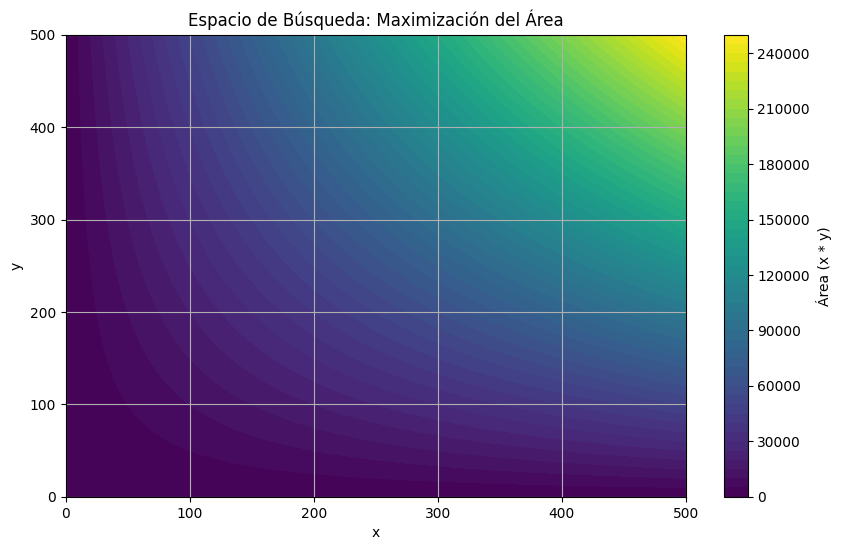

In [47]:
# Grafica del espacio de búsqueda basado en la funcion objetivo
# que es la maximización del área.
def plot_search_space():
    x = numpy.linspace(0, 500, 100)
    y = numpy.linspace(0, 500, 100)
    X, Y = numpy.meshgrid(x, y)
    Z = X * Y

    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Área (x * y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Espacio de Búsqueda: Maximización del Área')
    plt.xlim(0, 500)
    plt.ylim(0, 500)
    plt.grid()
    plt.show()

# Graficamos el espacio de búsqueda
plot_search_space()

## **Configuración de la Optimización por Enjambre de Partículas (PSO)**

### **1. Creación de Tipos con `creator`**
Se definen las estructuras de datos para el **Fitness** y la **Partícula**.

* **`FitnessMax`**: Define que el objetivo es de maximización (`weights=(1.0,)`).
* **`Particle`**: Define la estructura de una partícula. Además de ser una lista (para las coordenadas `[x, y]`), tendrá atributos adicionales específicos de PSO:
    * `speed`: La velocidad de la partícula.
    * `smin`, `smax`: Límites de la velocidad.
    * `best`: La mejor posición personal que ha encontrado la partícula hasta el momento.

In [35]:
# Crear los tipos de Fitness y Partícula
# weights=(1.0,) indica que es un problema de maximización.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Una partícula es una lista con atributos adicionales para PSO.
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best=None)

### **2. Funciones para Generar y Actualizar Partículas**
Se definen las funciones que controlan el comportamiento de las partículas en el enjambre.

* **`generate`**: Crea una partícula individual, asignándole una posición y velocidad inicial aleatoria dentro de los límites definidos (`pmin`, `pmax`, `smin`, `smax`).
* **`updateParticle`**: Implementa la lógica central de PSO. Actualiza la velocidad y la posición de una partícula en cada iteración, basándose en:
    * Su mejor posición histórica (`part.best`).
    * La mejor posición global encontrada por todo el enjambre (`best`).
    * Los factores cognitivo (`phi1`) y social (`phi2`).

In [36]:
# Función para generar una partícula con posición y velocidad iniciales aleatorias.
# size: número de variables de decisión.
# pmin, pmax: límites de la posición (valores para x, y).
# smin, smax: límites de la velocidad.
def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size))
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

In [37]:
# Función para actualizar la velocidad y posición de una partícula.
# part: partícula a actualizar.
# best: la mejor partícula del enjambre (gbest).
# phi1, phi2: factores cognitivo y social.
def updateParticle(part, best, phi1, phi2):
    # Componente cognitivo: tendencia hacia la mejor posición personal.
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    # Componente social: tendencia hacia la mejor posición global.
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    # Actualizar la velocidad y aplicar límites.
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    # Actualizar la posición de la partícula.
    part[:] = list(map(operator.add, part, part.speed))

### **3. Creación de la `Toolbox`**
Se registran todas las funciones y operadores en la `Toolbox` de DEAP para que el algoritmo pueda utilizarlos.

In [38]:
# Crear la caja de herramientas (Toolbox)
toolbox = base.Toolbox()

# Registrar la función para generar una partícula.
# size=2 (x,y), pmin/pmax (límites de posición), smin/smax (límites de velocidad).
toolbox.register("particle", generate, size=2, pmin=0, pmax=500, smin=-10, smax=10)

# Registrar la función para generar la población (una lista de partículas).
toolbox.register("population", tools.initRepeat, list, toolbox.particle)

# Registrar la función para actualizar las partículas.
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)

# Registrar la función de evaluación, decorada con la penalización DeltaPenalty.
# Si una solución no es factible (feasible=False), su fitness será -10000.
toolbox.register("evaluate", objective_function)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, -10000))

### **4. Definición de Parámetros y Estadísticas**
Se establecen los parámetros principales del algoritmo y se configura el registro de estadísticas.

In [39]:
# Parámetros del algoritmo PSO
initial_population = 100    # Número de partículas en el enjambre
num_ite = 100               # Número de iteraciones (generaciones)
best = None                 # Variable para almacenar la mejor partícula global

In [40]:
# Creación de la población inicial
pop = toolbox.population(n=initial_population)

In [41]:
# Configuración de las estadísticas a monitorear
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [42]:
# Configuración del Logbook para guardar el historial de estadísticas
logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

## **Ejecución del Algoritmo PSO**

Se inicia el bucle principal de optimización. En cada iteración:
1.  Se evalúa el fitness de cada partícula.
2.  Se actualiza la mejor posición personal (`part.best`) de cada partícula si encuentra una mejor.
3.  Se actualiza la mejor posición global (`best`) si alguna partícula supera el mejor valor conocido.
4.  Se actualiza la velocidad y posición de todas las partículas.
5.  Se registran y muestran las estadísticas de la generación.

In [43]:
# Bucle principal de la optimización PSO
for iteration in range(num_ite):
    for part in pop:
        # 1. Evaluar el fitness
        part.fitness.values = toolbox.evaluate(part)

        # 2. Actualizar mejor posición personal (pbest)
        if not part.best or part.best.fitness < part.fitness:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values

        # 3. Actualizar mejor posición global (gbest)
        if not best or best.fitness < part.fitness:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values

    # 4. Actualizar velocidad y posición de todas las partículas
    for part in pop:
        toolbox.update(part, best)

    # 5. Guardar y mostrar las estadísticas de la iteración
    logbook.record(gen=iteration, evals=len(pop), **stats.compile(pop))
    print(logbook.stream)

gen	evals	avg     	std    	min   	max    
0  	100  	-3927.57	10167.2	-10000	27326.5
1  	100  	-4467.34	9514.2 	-10000	24406.8
2  	100  	-3759.6 	10709.5	-10000	28877.2
3  	100  	-3264.6 	11420.1	-10000	30085.2
4  	100  	-3203.75	11636  	-10000	25645  
5  	100  	-2237.63	12976.1	-10000	29988  
6  	100  	-3257.51	12381.6	-10000	27625.5
7  	100  	-2910.75	12958.1	-10000	29735.8
8  	100  	-2289.24	13634.9	-10000	29064  
9  	100  	-1176.16	14794.5	-10000	31011.2
10 	100  	-340.599	15758.9	-10000	31017  
11 	100  	-1289.9 	15293.8	-10000	30910.7
12 	100  	-2002.83	14797.5	-10000	30672.3
13 	100  	-2268.59	14705.3	-10000	31125.6
14 	100  	-1250.68	15696.6	-10000	31073.9
15 	100  	-2269.49	15088  	-10000	31078.7
16 	100  	-2955.82	14620.2	-10000	31077.3
17 	100  	-1475.89	15663.1	-10000	29984.3
18 	100  	-527.029	16460.6	-10000	31040.1
19 	100  	22.7362 	16935.7	-10000	31140  
20 	100  	-1317.54	16358.5	-10000	30831.4
21 	100  	-4809.66	13431.5	-10000	31116  
22 	100  	-2801.23	15372.9	-10000	

## **Resultados Finales**

In [44]:
# Imprimir la mejor solución encontrada
print('Lado x (best[0]): ', best[0])
print('Lado y (best[1]): ', best[1])

Lado x (best[0]):  125.66204434231142
Lado y (best[1]):  248.6569440340106


In [45]:
# Evaluar la mejor solución
print('Área Máxima: ', best[0] * best[1])
print('Perímetro Utilizado: ', 2 * best[0] + best[1])

Área Máxima:  31246.739927225488
Perímetro Utilizado:  499.9810327186334


In [46]:
# Verificar si la solución es factible
feasible(best)

True